In [765]:
import re, orodja
import pandas as pd
import matplotlib.pyplot as plt
file = 'osu_index.txt'
aux_file = 'data-auxf.txt'
page = 'https://osu.ppy.sh/beatmapsets?sort=difficulty_desc&s=ranked'
word_file = 'words.txt'
word_page = 'https://en.wikipedia.org/wiki/Most_common_words_in_English'

## Auxilary code to make a file if one doesn't already exist

In [766]:
def create_files(files=[file, aux_file, 'data.json', 'data.csv']):
    for f in files:
        try:
            a = open(f, 'x')
            a.close()
        except:
            continue

Regex here

In [767]:
curr_re = r'\{"beatmapsets":\[(.*?)\]\}\]'
data_block_re = r'\{.*?\}\]\}'
data_re = re.compile(
    r'\{'
    r'"artist":(?P<artist>.*?)?,.*?,'
    r'"creator":(?P<creator>.*)?,' 
    r'"favourite_count":(?P<fav_count>\d*)?,.*?,'
    r'"id":(?P<id>\d*)?,.*?,'
    r'"play_count":(?P<play_count>\d*)?,.*?,'
    r'"status":(?P<status>.*)?,'
    r'"title":(?P<title>.*?)?,.*?,'
    r'"bpm":(?P<bpm>\d*)?,.*?'
    r'"tags":"(?P<tags>.*?)?",'
    r'"beatmaps":\[(?P<beatmapset>.*?)?\]'
    r'\}',
    flags=re.DOTALL
)

beatmapset_re = re.compile(
    r'\{.*?\}',
    flags=re.DOTALL
)

bmaux_re = re.compile(
    r'[^\\]',
    flags=re.DOTALL
)

beatmap_re = re.compile(
    r'\{.*?,'
    r'"difficulty_rating":(?P<difficulty_rating>.*?),'
    r'"id":(?P<id>\d*?),.*?,'
    r'"total_length":(?P<map_len>\d*?),.*?,'
    r'"accuracy":(?P<accuracy>.*?),'
    r'"ar":(?P<approach_rate>.*?),'
    r'"bpm":(?P<beatmap_bpm>\d*?),.*?,'
    r'"passcount":(?P<passcount>\d*?),'
    r'"playcount":(?P<playcount>\d*?),.*?,'
    r'"max_combo":(?P<max_combo>\d*?)\}',
    flags=re.DOTALL
)

## Separate code snippets here

In [768]:
def scrape(fin: str, out: str) -> None:
    regex = re.compile(curr_re, flags=re.DOTALL) #re.DOTALL postav piko na vse, vkljucno s novo vrstico
    with open(fin) as f:
        stuff = f.read()
        with open(out, 'w', encoding='UTF8')as o:
            print(re.findall(regex, stuff), file=o)

In [769]:
def make_blocks(filename: str) -> list:
    l = []
    with open(filename) as f:
        stuff = f.read()
    regex = re.compile(data_block_re, flags=re.DOTALL)
    for block in re.findall(regex, stuff):
        l.append(block)
    return l

In [770]:
def scrape_block(block: str) -> dict:
    if not block: return {}
    map = data_re.search(block).groupdict()
    map['fav_count'] = int(map.get('fav_count', 0))
    map['id'] = int(map.get('id', 0))
    map['play_count'] = int(map.get('play_count', 0))
    map['bpm'] = int(map['bpm']) 
    map['tags'] = map['tags'].split(' ')
    # map['beatmapset'] = scrape_beatmaps(map.get('beatmapset', ''))
    beatmapsset_string =  map.get('beatmapset', '')
    l = []
    for match in re.findall(r'\{.*?\}', beatmapsset_string):
        l.append(beatmap_re.search(match).groupdict())
    map['beatmapset'] = l
    return map

In [771]:
def error_check(block: str) -> bool: #eni so prazni iz nekga razloga
    try:
        scrape_block(block)
        return True
    except:
        print('Empty match!')
        return False

In [772]:
create_files()
orodja.shrani_spletno_stran(page, file, vsili_prenos=True)
scrape(file, aux_file)
data_blocks = make_blocks(aux_file)
data = []
for i, block in enumerate(data_blocks):
    if not error_check(block):
        print(i)
        continue
    data.append(scrape_block(block))
orodja.zapisi_json(data, 'data.json')
data_format = [
    'id', 
    'title', 
    'creator',
    'artist', 
    'fav_count', 
    'play_count', 
    'bpm', 
    'status', 
    'tags', 
    'beatmapset'
    ]
orodja.zapisi_csv(data, data_format, 'data.csv')

Empty match!
1
Empty match!
3
Empty match!
30
Empty match!
31
Empty match!
35
Empty match!
36
Empty match!
37


## Scraping done, moving on:

In [773]:
def filter_tags(l:list[str]) -> list[str]: #tole je nazalost treba ker unfiltered list item je ubistvu samo en doug string
    tags_re = re.compile(
        r'\w+',
        re.DOTALL
    )
    s = re.findall(tags_re, l)
    for i, chars in enumerate(s):
        if chars == '':
            s.pop(i)
    return s

In [774]:
def unicode_checker(s:str) -> bool:
    uni_re = re.compile(r'u[\d\w]{4}', flags=re.DOTALL)
    if re.match(uni_re, s): return True
    return False

In [775]:
def sort_tags(s: pd.Series, reverse=True) -> list[tuple]:
    tags_filtered = s.apply(filter_tags)
    u = {}
    for tags in tags_filtered:
        for tag in tags: #ta dvojn for loop je zelo fajn
            if unicode_checker(tag): continue
            if len(tag) <= 2: continue
            if u == {} or tag not in u.keys():
                u[tag] = 1
            else:
                u[tag] += 1
    return sorted(u.items(), key=lambda x:x[1], reverse=reverse)

## This part is the analysis of tag popularity among beat maps

In [776]:
df = pd.read_csv('data.csv')
subtable = df[['id', 'title', 'tags']]
subtable_by_playcount = df[['id', 'title', 'play_count']].sort_values('play_count', ascending=False)
all_tags_sorted = sort_tags(df.tags)
all_tags_sorted_table = pd.DataFrame(all_tags_sorted, columns=['Tag' , 'Appearances'])

In [777]:
orodja.shrani_spletno_stran(word_page, word_file, vsili_prenos=True)
word_re = r'<a href="https://en\.wiktionary\.org/wiki/(.*?)#English" class="extiw" title="wikt:(.*?)">(?P<word>.*?)</a>'
def common_words (filename) -> list:
    l = []
    with open(filename) as f:
        stuff = f.read()
    regex = re.compile(word_re, flags=re.DOTALL)
    for word in re.findall(regex, stuff):
        l.append(word[0])
    return l 
words = common_words('words.txt')

In [778]:
def filter_common_words(data: list, word_list=words):
    r = []
    for tag in data:
        if tag[0] not in word_list:
            r.append(tag)
    return r
tags_sorted_filtered = pd.DataFrame(filter_common_words(all_tags_sorted),columns=['Tag' , 'Appearances'])

<AxesSubplot: xlabel='Tag'>

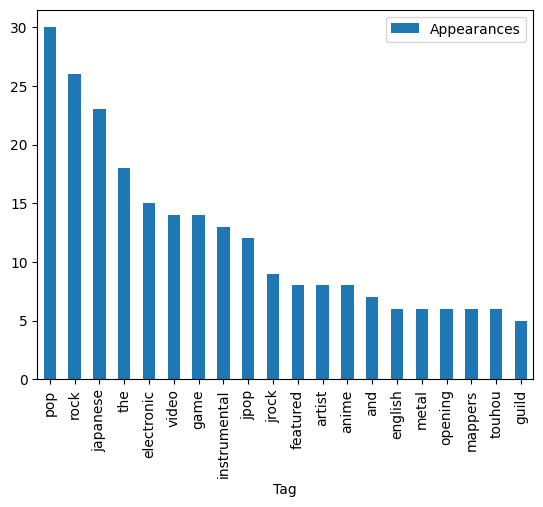

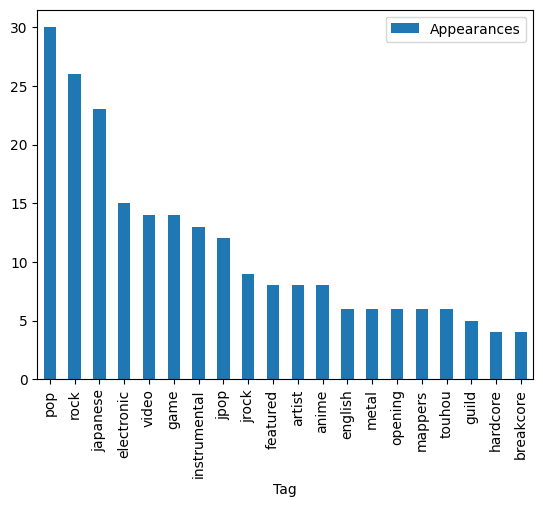

In [779]:
all_tags_sorted_table.head(20).plot.bar(x='Tag', y='Appearances') # Tale ne dela
tags_sorted_filtered.head(20).plot.bar(x='Tag', y='Appearances')

<AxesSubplot: xlabel='title'>

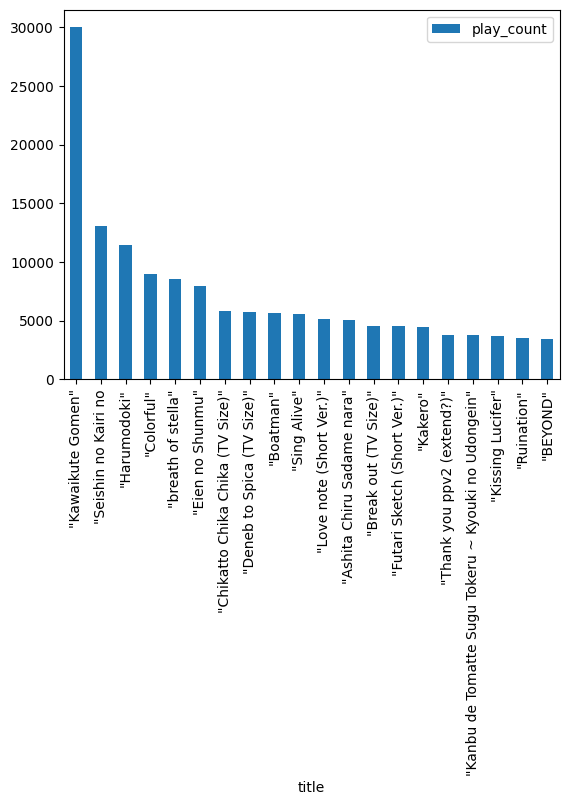

In [780]:
subtable_by_playcount = df[['id', 'title', 'play_count']].sort_values('play_count', ascending=False)
subtable_by_playcount.head(20).plot.bar(x='title', y='play_count')

## Bayes classificator goes here: predicting passcount for separate beatmaps given difficulty and playcount

_Additional note:_ This could be slightly problematic because lots of people are downloading the maps and just not playing them, + the difficulty is calculated based on a different classificator than just percentile

In [781]:
#I have to redefine df because of the way pandas reads from .csv files and .json files
df = pd.read_json('data.json')

In [782]:
# beatmaps_ranked_by_playcount = subtable_by_playcount.reset_index().drop('index', axis= 1)
def grab_index_from_title(df: pd.DataFrame, title: str):
    for i in range(df.size):
        if title.strip('"') in df.iloc[i].title:
            return i

def tags_in_top_tags(df: pd.DataFrame, title: str, top=20): 
    idx = grab_index_from_title(df, title)
    tag_list = df.iloc[idx].tags
    counter = 0
    for tag in list(tags_sorted_filtered.head(top).Tag):
        if tag in tag_list:
            counter += 1
    return counter

def popularity(df: pd.DataFrame, title: str):
    idx = grab_index_from_title(df, title)
    return round(tags_in_top_tags(df, title) / (len(list(df.iloc[idx].tags))), 4)

In [783]:
def total_passcount(df: pd.DataFrame, title: str): 
    idx = grab_index_from_title(df, title)
    beatmapset = df.beatmapset[idx]
    return sum([int(beatmap['passcount']) for beatmap in beatmapset])

In [784]:
def individual_passount(df: pd.DataFrame, title: str, beatmap: dict):
    return int(float(beatmap['playcount']) * int(float(beatmap['difficulty_rating'])) * (1 - float(beatmap['difficulty_rating']) / 10) * popularity(df, title))

def predict_passcount(df: pd.DataFrame, title: str): 
    idx = grab_index_from_title(df, title)
    return sum([individual_passount(df, title, beatmap) for beatmap in df.beatmapset[idx]])
# Unsure why, but the factor of 2 yields suprisingly accurate results
# Maybe the website also counts repeated attempts? In which case that would make sense, and the factor should be calculated based on difficulty? Maybe for each map do like the base difficulty times number of attempts?
# So far that is the most accurate, but honestly the two was just a blind guess

def deviation(df: pd.DataFrame, title: str):
    return abs(1 - predict_passcount(df, title) / total_passcount(df, title))

In [785]:
dat = dict()
dat['title'] = []
dat['actual_passcount']  = []
dat['predicted_passcount'] = [] 
dat['deviation'] = []
for a in df.iterrows():
    dat['title'].append(df.title[a[0]])
    dat['actual_passcount'].append(total_passcount(df, df.title[a[0]]))
    dat['predicted_passcount'].append(predict_passcount(df, df.title[a[0]]))
    dat['deviation'].append(deviation(df, df.title[a[0]]))
df['actual_passcount'] = dat['actual_passcount']
df['predicted_passcount'] = dat['predicted_passcount']
df['deviations'] = dat['deviation']
df

,artist,creator,fav_count,id,play_count,status,title,bpm,tags,beatmapset,actual_passcount,predicted_passcount,deviations
0,"""Lzie""","""Rinze""",3,1905994,124,"""ranked""","""[Utattemita] Nanairo no Tsundere [Gendai-ban]""",200,"[roxy-, kurokurokuro, ler1211, japanese, mashc...","[{'difficulty_rating': '7.19', 'id': '3930183'...",22,81,2.681818
1,"""BILLBOARDS""","""Genjuro""",20,1887133,521,"""ranked""","""ISCHEZAYU (LIELESS FRENCHCORE BOOTLEG)""",200,"[electronic, russian, hardcore, lielessx, \\u0...","[{'difficulty_rating': '5.84', 'id': '3886146'...",150,331,1.206667
2,"""Jefferson Airplane""","""allein""",30,1888186,1460,"""ranked""","""Somebody To Love""",133,"[surrealistic, pillow, psychedelic, rock, engl...","[{'difficulty_rating': '4.25', 'id': '3888610'...",219,987,3.506849
3,"""Yousei Teikoku""","""kowari""",27,1856477,1063,"""ranked""","""Fata Morgana""",200,[\\u30d5\\u30a9\\u30eb\\u30c6\\u30b7\\u30e2\\u...,"[{'difficulty_rating': '6.88', 'id': '3815421'...",111,397,2.576577
4,"""Camellia""","""gzdongsheng""",32,1824429,402,"""ranked""","""Qyoh (Nine Stars)""",242,"[electronic, instrumental, fa, featured, artis...","[{'difficulty_rating': '6.41', 'id': '3743608'...",92,162,0.760870
5,"""Koimi Eil (CV: Hachimitsuko)""","""TNTlealu""",24,1584423,5183,"""ranked""","""Love note (Short Ver.)""",183,"[suzuki, puyo, ore, no, cupid, ga, ponkotsu, s...","[{'difficulty_rating': '5.7', 'id': '3236407',...",1154,1717,0.487868
6,"""Da-iCE""","""Vanya2""",20,1672200,4571,"""ranked""","""Break out (TV Size)""",185,"[alevi, vinal2, [_lost_], conner, c_o_n_n_e_r,...","[{'difficulty_rating': '3.32', 'id': '3417438'...",1255,3345,1.665339
7,"""meganeko""","""AutotelicBrown""",26,1895713,1422,"""ranked""","""The Cyber Grind""",190,"[original, soundtrack, ost, act, i, infinite, ...","[{'difficulty_rating': '4.09', 'id': '3906827'...",381,482,0.265092
8,"""sakuraburst""","""hytaa""",45,1667697,1000,"""ranked""","""cherry blossoms explode across the dying hori...",156,"[featured, artist, fa, deconstructing, nature,...","[{'difficulty_rating': '5.63', 'id': '3405178'...",133,459,2.451128
9,"""HMMMM""","""Kimitakari""",7,1915695,85,"""ranked""","""Kuroiuta""",80,"[nelly, lunicia, kuroi, uta, black, song, cove...","[{'difficulty_rating': '4.67', 'id': '3952236'...",13,18,0.384615


In [789]:
len(df.sort_values('deviations', ascending=True)[df.deviations <= 1])

/var/folders/h_/2ln7jfx526z8ww861fjjjbh80000gn/T/ipykernel_27509/2641427609.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df.sort_values('deviations', ascending=True)[df.deviations <= 1])


27

### This next one is of ***FIGURATIVE*** nature, caution is advised

Run this snippet only if you want to _spawn satan himself onto this world_, otherwise it's unnecessary

In [ ]:
%%script false --no-raise-error
figure1, ax1 = plt.subplots()
ax1.pie(all_tags_sorted_table.Appearances, labels=all_tags_sorted_table.Tag, autopct='%1.1f%%', shadow=False, startangle=0)
ax1.axis('equal')
plt.title('The Antichrist')
#i'm submitting  this one just because of how cursed it is head(20)
plt.show()

### Random stuff

## PLAN

Take beatmap -> scan through its tags -> based on how many tags the map has from the top say 20 tags make percent on how many players play each map -> for each beatmap in beatmap set take the percentage * difficulty to predict passcount -> sum for total predicted passcount -> sum over whole beatmap set for beatmap for actual passcount -> compare

Reason: some people download maps and never play them, or just give them a shot, but most drop it before it's completed. This is most likely due to disinterest